# Manually setting severity of a continuous score

In [1]:
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType, LongType
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Loading data

Read in the data being used to create the score

In [2]:
ROOT_PATH="gs://green-1-accelerators-1-username-dpr-stg-bucket/"
FILE_PATH="customer/DocumentDataModel/CleansedDocumentDataModel.parquet"

In [3]:
customers = spark.read.parquet(ROOT_PATH+FILE_PATH)

Select the relevant columns, in this case customerIdNumber and customerRiskRating. 

In [4]:
cust_risk = customers.select("customerIdNumber", "customerRiskRating")

In [5]:
cust_risk.printSchema()

root
 |-- customerIdNumber: long (nullable = true)
 |-- customerRiskRating: integer (nullable = true)



Convert to pandas dataframe

In [6]:
cust_risk_pd = cust_risk.toPandas()

In [7]:
cust_risk_pd.head(10)

,customerIdNumber,customerRiskRating
0,1937937421,NaN
1,5085464662,1781.0
2,6029246402,5285.0
3,10092942152,6225.0
4,10910136667,9876.0
5,14790341630,NaN
6,24986141054,NaN
7,28471596220,2968.0
8,34113997963,NaN
9,35067368037,2413.0


### Analyse distribution of data

#### Inspect the distribution of the customer risk rating

In [8]:
cust_risk_pd['customerRiskRating'].describe()

count    1170.000000
mean     5074.023077
std      2905.695932
min        10.000000
25%      2611.750000
50%      5056.000000
75%      7652.500000
max      9992.000000
Name: customerRiskRating, dtype: float64

In [9]:
number_of_null_values = cust_risk_pd['customerRiskRating'].isna().sum()

We check for NaN (null) values as we don't want to include these in the analysis and subsequently remove from the dataframe.

There are {{number_of_null_values}} null values which we will remove

In [10]:
cust_risk_pd = cust_risk_pd.dropna()

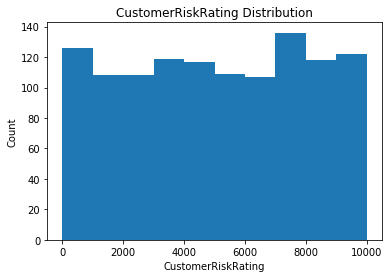

In [11]:
n, binvals, patches = plt.hist(cust_risk_pd["customerRiskRating"],bins=10)
plt.title("CustomerRiskRating Distribution")
plt.xlabel("CustomerRiskRating")
plt.ylabel("Count")
plt.show()

It can also be helpful to look at quantiles of the data.

In [12]:
num_quantiles=10
quantiles=cust_risk_pd['customerRiskRating'].quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
quantiles

0.0      10.0
0.1     967.6
0.2    2007.4
0.3    3045.4
0.4    4051.6
0.5    5056.0
0.6    6202.8
0.7    7227.0
0.8    8047.4
0.9    9018.6
Name: customerRiskRating, dtype: float64

In [13]:
max_risk=cust_risk.select(f.max('customerRiskRating')).head()[0]

In [14]:
quantile_count=cust_risk.filter(f.col('customerRiskRating').isNotNull()).count()/num_quantiles

In [19]:
#Project Example does not have a source of "known bad" currently.
#This variable is intended to mimic this source of known bads for the purpose of explanation further down
historical=[1,3,2,2,2,3,5,6,8,10]

In [16]:
new_bins=quantiles.append(pd.Series(max_risk,index=[1]))

Use the quantiles to calculate the number of transactions in each bin.

In [17]:
counts, bins = np.histogram(cust_risk_pd["customerRiskRating"],bins=new_bins)

In [18]:
counts, bins

(array([117, 117, 117, 117, 117, 117, 116, 118, 117, 117]),
 array([  10. ,  967.6, 2007.4, 3045.4, 4051.6, 5056. , 6202.8, 7227. ,
        8047.4, 9018.6, 9992. ]))

Obtain business input as to the relative risk and when the score should trigger

**NB:** The table below is created using a Python Markdown extension which allows for mixing markdown code and python code. As such some values are calculated and some are static within the markdown itself. For more details see documentation for ipython-contrib/jupyter_contrib_nbextensions on github.


| Scenario output value range|No. transactions|No. historical cases|Historical hit rate|Business feedback  |
|----|----|----|----|:----|
|{{round(bins[0],2)}}-{{round(bins[1],2)}} |{{counts[0]}}|{{historical[0]}}|{{round(historical[0]/counts[0],2)}}%|Not interesting - scenario should not trigger|
|{{round(bins[1],2)}}-{{round(bins[2],2)}} |{{counts[1]}}|{{historical[1]}}|{{round(historical[1]/counts[1],2)}}%|Not interesting - scenario should not trigger|
|{{round(bins[2],2)}}-{{round(bins[3],2)}} |{{counts[2]}}|{{historical[2]}}|{{round(historical[2]/counts[2],2)}}%||
|{{round(bins[3],2)}}-{{round(bins[4],2)}} |{{counts[3]}}|{{historical[3]}}|{{round(historical[3]/counts[3],2)}}%||
|{{round(bins[4],2)}}-{{round(bins[5],2)}} |{{counts[4]}}|{{historical[4]}}|{{round(historical[4]/counts[4],2)}}%||
|{{round(bins[5],2)}}-{{round(bins[6],2)}} |{{counts[5]}}|{{historical[5]}}|{{round(historical[5]/counts[5],2)}}%|Not interesting - scenario should not trigger|
|{{round(bins[6],2)}}-{{round(bins[7],2)}} |{{counts[6]}}|{{historical[6]}}|{{round(historical[6]/counts[6],2)}}%|{{round(bins[6],2)}} is minimum level. <br> 5 times less risky than worst risk|
|{{round(bins[7],2)}}-{{round(bins[8],2)}} |{{counts[7]}}|{{historical[7]}}|{{round(historical[7]/counts[7],2)}}%||
|{{round(bins[8],2)}}-{{round(bins[9],2)}} |{{counts[8]}}|{{historical[8]}}|{{round(historical[8]/counts[8],2)}}%||
|{{round(bins[9],2)}}-{{round(bins[10],2)}} |{{counts[9]}}|{{historical[9]}}|{{round(historical[9]/counts[9],2)}}%|Maximum risk at {{round(bins[9],2)}}|

These values can now be used in the severityFromContinuousValue calculator where minValue~{{round(bins[6],2)}}, maxValue~{{round(bins[9],2)}} and minSeverity=20. This follows the approach for calculating continuous severities documented in https://quantexa.atlassian.net/wiki/spaces/TECH/pages/80281674/Standard+Approach+to+Manually+Assigning+Severity+to+Scenario+Output <br>
**NB:** Although we are reporting by quantile (and it is easier for the business to give feedback on this) we prefer to map continuous variables to a continuous severity.

We can now use the details above and a severity calculator function to calculate the severities for different customer risk ratings. 

In [32]:
def severityFromContinuousValue(value, minValue, maxValue, minSeverity, maxSeverity=100):
    """
    A python version of the scala function in analytical-incubators.
    """
    if (minValue > maxValue):
        raise ValueError("Minimum value must not be greater than maximum value")
    if (minSeverity > maxSeverity):
        raise ValueError("Minimum severity must not be greater than maximum severity")
    if value < minValue:
        severity = 0
    elif value > maxValue:
        severity = 100
    else:
        gradient  = (maxSeverity - minSeverity) / (maxValue - minValue)
        intercept = maxSeverity - gradient * maxValue
        severity = gradient * value + intercept
    return int(severity)

To calculate the severity of a customer risk rating of 7000 we use `severityFromContinuousValue(7000,{{round(bins[6],2)}},{{round(bins[9],2)}},20)`. <br> Below we show how the customer risk ratings map to severities.

In [43]:
severity_list = []
for index, row in cust_risk_pd.iterrows():
    severity_list.append(severityFromContinuousValue(row[1],round(bins[6],2),round(bins[6],2),20))

In [37]:
cust_risk_pd["severity"] = severity_list

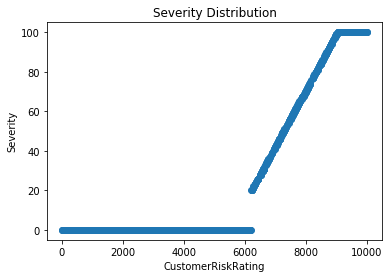

In [42]:
plt.scatter(cust_risk_pd["customerRiskRating"],cust_risk_pd["severity"])
plt.title("Severity Distribution")
plt.xlabel("CustomerRiskRating")
plt.ylabel("Severity")
plt.show()

The above plot shows that for scenario output values between {{round(bins[6],2)}} and {{round(bins[9],2)}} we linearly scale severity between the minimum (20) and maximum (100) severities 